In [25]:
import numpy as np 
import copy
import torch
import time
import pickle

from IMP_CW_env import MESCEnv
from utils import *

%matplotlib inline
# %matplotlib ipympl
import matplotlib.pyplot as plt

# **1. Training environment definition**

In [26]:
n_retailers = 2
n_DCs = 1
n_suppliers = 1
supply_chain_structure = [[n_retailers] , [n_DCs], n_suppliers]

env_train = MESCEnv(supply_chain_structure, num_periods = 7*4)

# **2. Policy Network**
[comment]: <> (MLPregresor from sklearn is not used because you cannot specify input and output shapes prior to calling the fit method. Since in the ES approach it won't be used, we build NN using Pytorch.)

In [27]:
class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size, h1_size = 128, h2_size = 64,):
        super(PolicyNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, h1_size)
        self.fc2 = torch.nn.Linear(h1_size, h2_size)
        self.fc3 = torch.nn.Linear(h2_size, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x 

# **3. Policy optimization**
To obtain the optimal policies, different methods can be used. 
- **Heuristic methods**, like the (s,S) policy
- **Meta-heuristic algorithms**, like simulated annealing (SA) or particle-swarm optimization (PSO).
- **RL-specific algorithms**, such as Q-learning or REINFORCE.

## 3.1 Simulated Annealing
Simulated Annealing is a simple optimization technique inspired by the thermodynamic process of cooling metal. The algorithm iteratively explores the feasible region, accepting better solutions and, at times, worse solutions based on a probability function driven by temperature. Over time, the "temperature" decreases, reducing the likelihood of accepting worse solutions. 

You can find more information about it [here](https://www.baeldung.com/cs/simulated-annealing), but the basic flowchart is shown below.

<div>
<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2023/03/flowchart.png" width="500"/>
</div>



#### **Helper Functions**

To get started, two functions are pre-coded for you:

* `sample_uniform_params` --> samples a random point within given parameter bounds.
* `sample_local_params` --> sample a random point in the neighborhood of a given point.

Note that we will use both of these function to evaluate your submission. Should you wish to use a different sampling function, you have to define it WITHIN your algorithm!

In [ ]:
def sample_uniform_params(params_prev, param_min, param_max):
    '''
    Sample random point within given parameter bounds. Tailored for EXPLORATORY purposes
    '''
    params = {k: torch.rand(v.shape) * (param_max - param_min) + param_min \
              for k, v in params_prev.items()}
    return params

def sample_local_params(params_prev, param_min, param_max):
    '''
    Sample a random point in the neighborhood of a given point or value or the parameters (v). Tailored for EXPLOITATION purposes

    Explanation:
    sign = (torch.randint(2, (v.shape)) * 2 - 1) # This returns either -1 or 1
    eps = torch.rand(v.shape) * (param_max - param_min) # This returns the width of the step to be taken in the modification of the parameters
    Hence, the total update is: v + sign*eps.
    '''
    params = {k: torch.rand(v.shape) * (param_max - param_min) * (torch.randint(2, (v.shape))*2 - 1) + v \
              for k, v in params_prev.items()}
    return params

### **Implementation**

In [ ]:
#####################
# Objective function 
######################
def reward_fcn(policy_net, env, num_episodes=10, demand=None):
    '''
    Runs an episode and computes the total return.
    '''
    assert num_episodes > 0, "Number of episodes must be greater than 0"

    env.demands_episode = demand
    reward_list = []

    for i in range(num_episodes):
        # Reset environment before each episode
        env.reset()
        state = env.state
        episode_terminated = False
        # Initialize reward counter
        total_reward = 0
        
        while episode_terminated == False:
            # Pre-process state
            state = torch.FloatTensor(state)

            # Get action according to the policy network
            action_mean = policy_net(state)
            action_mean = action_mean.detach().numpy()
            action_mean = np.floor(action_mean)
            
            # Interact with the environment to get reward and next state
            state , reward, episode_terminated, _ = env.step(action_mean)
            total_reward += reward
           
        reward_list.append(total_reward)
        
    mean_reward = np.mean(reward_list)
    std_reward = np.std(reward_list)
    return mean_reward, std_reward

#################################
# 2-Phase Policy Optimization
#################################
def train_policy_SA(env, *,
                    param_min = -1.,
                    param_max = 1.,
                    num_episodes_avg = 10 ,
                    max_iter = 100, 
                    ratio_rs_ls = 0.1, 
                    NNparams_0 = None,
                    initial_temp = 1e5, 
                    max_time = 30, # maximum execution time in seconds
                    ):
    
    assert initial_temp > 0 , "inital_temp must be a positive value"

    # Setup iterations
    iter_rs = round(max_iter * ratio_rs_ls)
    iter_ls = max_iter - iter_rs

    # Initialize buffers to store data for plotting
    reward_history = []
    std_history = []
    best_reward_history = []

    # Policy initialization
    policy_net = PolicyNetwork(input_size=env.observation_space.shape[0], 
                               output_size=env.action_space.shape[0])
    param = policy_net.state_dict() if NNparams_0 is None else NNparams_0 

    # Initialization
    best_param = copy.deepcopy(param)
    best_reward, best_std = reward_fcn(policy_net, env, num_episodes=num_episodes_avg)
    reward_history.append(best_reward)
    std_history.append(best_std)
    best_reward_history.append(best_reward)
    i = 0

    # Define path to store best policies
    save_path = setup_model_saving(algorithm="SA")
    print(f"Policy model weights saved in: {save_path}")

    # Initialize timer
    start_time = time.time()

    # # ###########################################################   
    # # Random search phase: generate good initial solution
    # # ###########################################################
    if NNparams_0 is None:
        while (i < iter_rs) and (i < max_iter) and ((time.time()-start_time) < max_time):
            # Update iteration counter
            i += 1

            # Sample a random policy
            current_param = sample_uniform_params(param, param_min, param_max)
            # Construct the policy network with the sampled parameters
            policy_net.load_state_dict(current_param)
            # Evaluate the policy
            reward, std = reward_fcn(policy_net, env, num_episodes=num_episodes_avg)
            reward_history.append(reward)
            std_history.append(std)

            if not np.isfinite(reward):
                print(f"Reward overflow: {reward}")

            # Check if the new policy is better than the best one found so far
            if reward > best_reward:
                best_reward = reward
                best_param = copy.deepcopy(param)

            # Store the best reward found so far for plotting
            best_reward_history.append(best_reward)

    # ###########################################################
    # Local search phase: Simulated Annealing
    # ###########################################################

    # Set current working solution
    current_param = copy.deepcopy(best_param)
    current_reward = best_reward
    # Reset iteration counter
    i = 0

    while i < (max_iter - iter_rs) and ((time.time()-start_time) < max_time):
        # Update iteration counter
        i += 1
        
        # Sample a new policy in the neighborhood of the current one
        # TODO: check if ok or leave it like sample_uniform_params
        candidate_param = sample_local_params(current_param, param_min, param_max)

        # Evaluate the candidate policy
        policy_net.load_state_dict(candidate_param)
        candidate_reward, std = reward_fcn(policy_net, env, num_episodes=num_episodes_avg)

        # Check if the candidate policy is better than the current one
        if candidate_reward > best_reward:
            # Update the new best policy
            best_reward = candidate_reward
            best_param = copy.deepcopy(candidate_param)
            # Save policy
            torch.save(policy_net.state_dict(), save_path)
            
        # Check if the candidate policy should be kept or discarded
        diff = candidate_reward - current_reward
        temp = initial_temp / (1 + i) # update temperature paramter
        metropolis = np.exp(diff/temp) # compute metropolis acceptance probability
        if diff > 0 or np.random.rand() < metropolis:
            # Update the current policy 
            current_param = copy.deepcopy(candidate_param)
            current_reward = candidate_reward
        
        # Store the data for plotting
        reward_history.append(candidate_reward)
        std_history.append(std)
        best_reward_history.append(best_reward)

    if time.time() - start_time > max_time:
        print("Timeout reached: the best policy found so far will be returned.")

    # Pack data for plotting
    plot_data = {'reward_history': reward_history,
                'std_history': std_history,
                'best_reward_history': best_reward_history}
            
    print(f"Policy model weights saved in: {save_path}")
    print(f"Best reward found during training: {best_reward}")
            
    return save_path , plot_data

### **Policy training**

In [29]:
hyperparamSA = {}
# Problem specs 
hyperparamSA['param_min'] = -1.
hyperparamSA['param_max'] = 1.
hyperparamSA['num_episodes_avg'] = 5
# Algorithm-specific hyperparameters
hyperparamSA['initial_temp'] = 1e7
hyperparamSA['max_iter'] = 50
hyperparamSA['ratio_rs_ls'] = .05
# Execution control
hyperparamSA["max_time"] = 60

By running the cell below, your training algorithm will be executed using the hyperparameter configuration you defined above.

In [ ]:
np.seterr(over='ignore')  # Suppress overflow warnings
# np.seterr(over='warn')  # Re-enable overflow warnings

policySA_model_path , plot_info = train_policy_SA(env_train, **hyperparamSA)

Policy model weights saved in: SA_policies//SA_policy_20.pt
Best reward: 12437.2


### **Training analysis:** plot reward evolution during training.

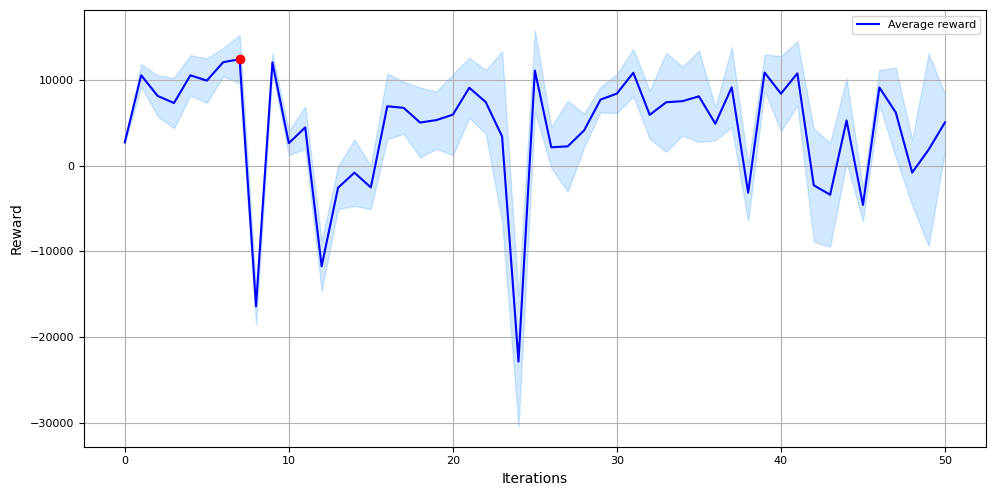

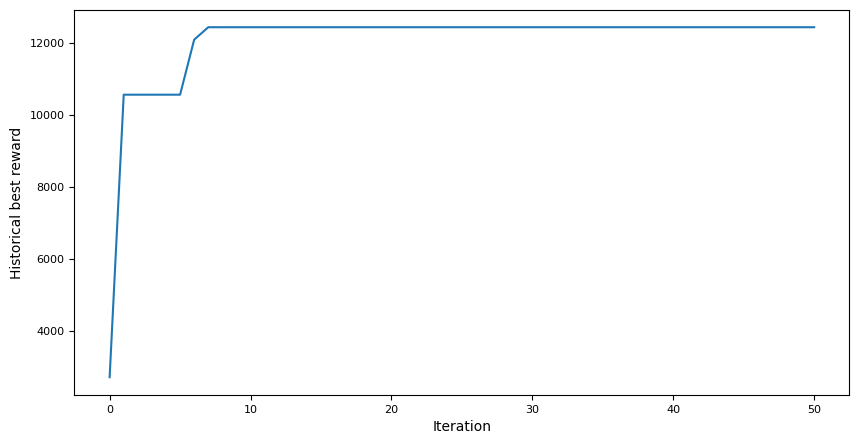

In [31]:
# Plot solution evolution per iteration
plot_reward_evolution(list(range(len(plot_info['reward_history']))), plot_info['reward_history'], reward_std=plot_info['std_history']);

# Plot historical best reward
plt.plot(list(range(len(plot_info['best_reward_history']))), plot_info['best_reward_history'])
plt.xlabel('Iteration')
plt.ylabel('Historical best reward');

# **4. REINFORCE with baseline**

REINFORCE is a foundational RL algorithm that belongs to the familiy of policy-based methods. REINFORCE updates the probability of taking specific actions in certain states based on how much those actions contributed to higher overall rewards in past episodes. The policy being learned is the same policy used to generate the data the agent uses to learn, hence "on-policy".

<div>
<img src="https://lcalem.github.io/imgs/sutton/reinforce_baseline.png" width="800"/>
</div>

### **Implementation**

In [ ]:
#################################
# Helper functions
#################################
class ValueNetwork(torch.nn.Module):
    def __init__(self, input_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def choose_action(state, policy_net, action_std):
    '''
    Sample action in continuous action space modelled with a Multivariate Normal distribution
    '''
    # Predict action mean from Policy Network
    action_mean = policy_net(torch.from_numpy(state).float())

    # Estimate action variance (decaying action std)
    action_var = torch.full(size=(policy_net.fc3.out_features,) , fill_value = action_std**2)
    cov_mat = torch.diag(action_var).unsqueeze(dim=0) 

    # Generate Multivariate Normal distribution with estimated mean and variance
    dist = torch.distributions.MultivariateNormal(action_mean, cov_mat)

    # Sample action
    action = dist.sample()

    # Compute logprob and entropy
    logprob = dist.log_prob(action)
    entropy = dist.entropy()

    return action, logprob , entropy

###########################################
# REINFORCE with baseline implementation
###########################################
def train_policy_REINFORCE( env, *, 
                            h1_size = 128, 
                            h2_size = 64,
                            lr_policy_net= 5e-5, 
                            lr_value_net = 1e-5, 
                            discount_factor = .99 , 
                            max_steps = 1e5, 
                            max_time = 120. ,
                            weight_entropy = 0.001, 
                            action_std_init = .5):
    
    # Create log file
    log_f_path = setup_logging(algorithm = "REINFORCE")
    log_f = open(log_f_path, 'w+')
    log_f.write("Timestep,Reward\n")
    # Create file to store model weigths
    save_f_path = setup_model_saving(algorithm = "REINFORCE")

    # Initialize variables
    counter_timesteps = 0
    best_reward = -np.inf
    start_time = time.time()
    
    # Initialize policies and optimizers
    policy_net = PolicyNetwork( input_size=env.observation_space.shape[0], output_size=env.action_space.shape[0],
                                h1_size = h1_size,
                                h2_size = h2_size,)
    value_net = ValueNetwork(input_size=env.observation_space.shape[0])
    optimizer_policy = torch.optim.Adam(policy_net.parameters(), lr=lr_policy_net)
    optimizer_value = torch.optim.Adam(value_net.parameters(), lr=lr_value_net)

    while (counter_timesteps < max_steps) and ((time.time()-start_time) < max_time):
        
        # Run an episode and collect experience
        trajectory = {}
        trajectory["values"] = []
        trajectory["actions"] = []
        trajectory["logprobs"] = []
        trajectory["rewards"] = []
        trajectory["entropies"] = []

        done = False
        env.reset()
        state = env.state
        
        while not done:
            action , action_logprob , entropy = choose_action(state, policy_net, action_std_init)
            next_state , reward , done , _ = env.step(action.detach().numpy().flatten())

            trajectory["values"].append(value_net(torch.from_numpy(state).float()))
            trajectory["logprobs"].append(action_logprob)
            trajectory["rewards"].append(reward)
            trajectory["entropies"].append(entropy)

            state = next_state
            counter_timesteps += 1
        
        logprobs = torch.stack(trajectory["logprobs"]).squeeze() # shape : (episode_length, )
        entropies = torch.stack(trajectory["entropies"]).squeeze() # shape : (episode_length, )
        values = torch.stack(trajectory["values"]).squeeze() # shape : (episode_length, )

        # Calculate discounted return at every time step
        discounted_return = 0
        returns = []
        for r in reversed(trajectory["rewards"]):
            discounted_return = r + discount_factor * discounted_return
            returns.insert(0, discounted_return)
        returns = torch.tensor(returns , dtype=torch.float32)

        # Compute policy loss
        advantages = returns - values
        advantages = (advantages - advantages.mean()) / advantages.std()
        loss_policy = (-1) * torch.mean(advantages.detach() * logprobs) + weight_entropy * ((-1) * torch.mean(entropies))

        # Compute value loss
        loss_value = torch.nn.functional.mse_loss(values , returns)

        # Update policy network
        optimizer_policy.zero_grad()
        loss_policy.backward()
        optimizer_policy.step()

        # Update Value Network
        optimizer_value.zero_grad()
        loss_value.backward()
        optimizer_value.step()

        # Write episode undiscounted return to log file
        total_return = round(np.mean(sum(trajectory["rewards"])), 4)
        log_f.write('{:.0f},{:.3f}\n'.format(counter_timesteps, total_return))
        log_f.flush() 

        # Save best policy
        if total_return > best_reward:
            best_reward = total_return
        torch.save(policy_net.state_dict(), save_f_path)

    # Close log file
    log_f.close()
    
    print(f"Log file saved in: {log_f_path}") 
    print(f"Policy model weights saved in: {save_f_path}") 
    print(f"Best reward: {best_reward}")

    return save_f_path , log_f_path

### **Hyperparamter definition**

In [44]:
hyperparamRL = {}
hyperparamRL["max_steps"] = env_train.n_periods * 500 # env_train.n_periods returns the episode length
hyperparamRL["weight_entropy"] = .01

### **Policy training** 

In [ ]:
policyRL_model_path , log_file_path = train_policy_REINFORCE(env_train, **hyperparamRL)

Log file saved in: REINFORCE_logs//REINFORCE_log_5.csv
Policy model weights saved in: REINFORCE_policies//REINFORCE_policy_4.pt
Best reward: 4412.5


### **Training analysis:** plot reward evolution during training

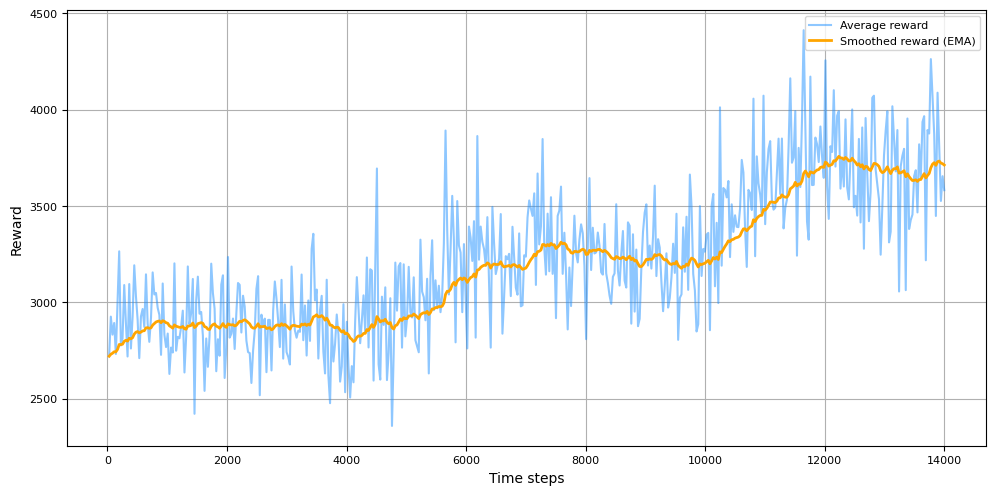

In [46]:
timesteps, rewards = read_log_file(log_file_path)
plot_reward_evolution(timesteps, rewards)

# **5. Policy evaluation**
### **5.1. Test data**: get new demand scenarios
The variable test_demand_dataset contains 100 samples of demand scenarios, each with 52 weeks, that will be used for testing and comparing the extrapolation capabilities of the different policies.

In [36]:
# Open the file in binary mode
with open("test_demand_dataset.pickle", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    test_demand_dataset = pickle.load(file)

### **5.2. Evaluate optimal policies**
To assess the performance of each algorithm, the optimal policies are evaluated on the test dataset to compute the average undiscounted return.

In [37]:
#######################################################
# Evaluation function
#######################################################
def calculate_average_return(policy , env , demand):
    '''
    Runs an episode and computes the total return.
    '''
    reward_list = []

    for i in range(len(demand)):
        # Set the demand of each episode
        env.demand_dataset = demand[i]
        # Reset environment before each episode
        env.reset()
        state = env.state
        episode_terminated = False
        # Initialize reward counter
        total_reward = 0
        
        while episode_terminated == False:
            # Pre-process state
            state = torch.FloatTensor(state)

            # Get action according to the policy network
            action_mean = policy(state)
            action_mean = action_mean.detach().numpy()
            action_mean = np.floor(action_mean)
            
            # Interact with the environment to get reward and next state
            state , reward, episode_terminated, _ = env.step(action_mean)
            total_reward += reward

        reward_list.append(total_reward)
    
    return reward_list

In [38]:
reward_list = {}

In [ ]:
# Load policy derived using Simulated Annealing
policySA = PolicyNetwork(input_size=env_train.observation_space.shape[0], output_size=env_train.action_space.shape[0]) 
policySA.load_state_dict(torch.load(policySA_model_path))

# Compute average undiscounted return
reward_list["SA"] = []
rewardSA = calculate_average_return(policySA, env_train, test_demand_dataset)
reward_list["SA"].append(rewardSA)

# Print results
print("Performance of SA:\n - Average reward: {:.2E}\n - Reward standard deviation: {:.2E}".format(np.mean(reward_list["SA"]), np.std(reward_list["SA"])))

Performance of SA:
 - Average reward: 1.08E+04
 - Reward standard deviation: 2.47E+03


In [47]:
# Load policy derived using REINFORCE with baseline
policyRL = PolicyNetwork(input_size=env_train.observation_space.shape[0], output_size=env_train.action_space.shape[0],)
policyRL.load_state_dict(torch.load(policyRL_model_path))

# Compute average undiscounted return
reward_list["RL"] = []
rewardRL = calculate_average_return(policyRL, env_train, test_demand_dataset)
reward_list["RL"].append(rewardRL)

# Print results
print("Performance of RL:\n - Average reward: {:.2E}\n - Reward standard deviation: {:.2E}".format(np.mean(reward_list["RL"]), np.std(reward_list["RL"])))

Performance of RL:
 - Average reward: 2.82E+03
 - Reward standard deviation: 8.64E+01


Evaluate a pre-computed optimal heuristic policy for comparison purposes.

In [41]:
from HeuristicPolicy_file import HeuristicPolicy

sSpolicy = HeuristicPolicy()
sSpolicy.policy_param = np.array([11., 30., 20., 34., 61., 76.])
reward_list["sS"] = sSpolicy.evaluate_policy(env_train, test_demand_dataset)
print("Heuristic policy performance:\n - Average reward: {:.2E}\n - Reward standard deviation: {:.2E}".format(np.mean(reward_list["sS"]), np.std(reward_list["sS"])))

Heuristic policy performance:
 - Average reward: 1.31E+04
 - Reward standard deviation: 2.29E+03


### **5.3 Result analysis:** reward distribution

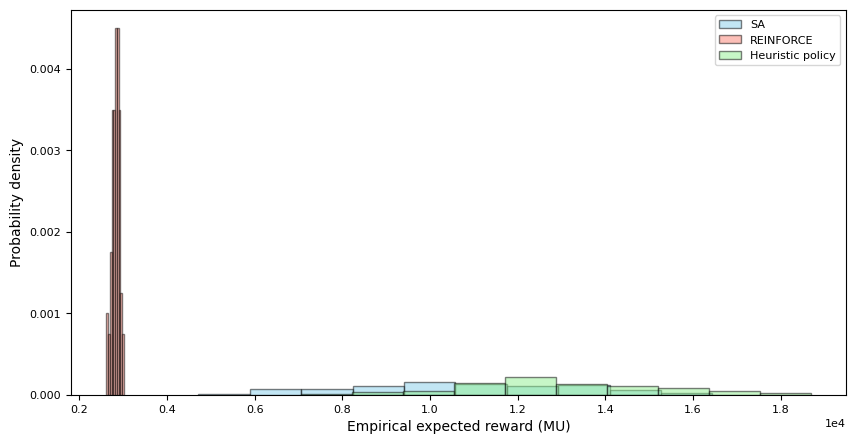

In [48]:
plot_reward_distribution(np.vstack([reward_list["SA"],reward_list["RL"],reward_list["sS"]]).T, labels=['SA', 'REINFORCE', 'Heuristic policy'])